In [55]:
from ema_workbench import load_results
from ema_workbench.analysis import parcoords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

experiments, outcomes = load_results('basecase_results.tar.gz') 

In [5]:
outcomes_df = pd.DataFrame.from_dict(outcomes)

In [6]:
outcomes_df

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0.000000e+00,0,0.000000,4.956143e+07,0,0.034111,0.000000e+00,0,0.000000,0.000000e+00,...,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
1,7.981894e+08,0,0.511273,1.982271e+06,0,0.001840,1.879098e+07,0,0.032753,0.000000e+00,...,0,0.032753,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
2,1.020723e+09,0,0.502317,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,...,0,0.000000,0.000000e+00,0,0.000000,1.208215e+06,0,0.001036,0.0,0.0
3,5.212225e+08,0,0.511131,7.616511e+06,0,0.009785,0.000000e+00,0,0.000000,0.000000e+00,...,0,0.000000,0.000000e+00,0,0.000000,1.309255e+06,0,0.001357,0.0,0.0
4,0.000000e+00,0,0.000000,2.063872e+07,0,0.023595,0.000000e+00,0,0.000000,1.751962e+05,...,0,0.000000,1.751962e+05,0,0.000106,1.296208e+06,0,0.001435,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.030883e+09,0,0.508581,0.000000e+00,0,0.000000,3.177024e+07,0,0.040878,7.248716e+06,...,0,0.040878,5.588852e+06,0,0.002215,0.000000e+00,0,0.000000,0.0,0.0
996,3.493332e+08,0,0.228883,1.566571e+06,0,0.001394,5.537586e+07,0,0.093376,3.964449e+07,...,0,0.093376,2.589386e+07,0,0.016136,0.000000e+00,0,0.000000,0.0,0.0
997,5.230978e+08,0,0.513428,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,9.752698e+05,...,0,0.000000,9.752698e+05,0,0.000657,0.000000e+00,0,0.000000,0.0,0.0
998,1.698119e+08,0,0.172083,1.961674e+07,0,0.026251,5.437033e+07,0,0.140718,0.000000e+00,...,0,0.140718,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0


In [13]:
outcomes_df[['A.5_Expected Annual Damage 0', 'A.5_Expected Annual Damage 1', 'A.5_Expected Annual Damage 2']]

,A.5_Expected Annual Damage 0,A.5_Expected Annual Damage 1,A.5_Expected Annual Damage 2
0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00
2,1.567050e+06,7.891476e+05,1.208215e+06
3,1.073405e+06,1.643425e+06,1.309255e+06
4,1.296208e+06,1.296208e+06,1.296208e+06
...,...,...,...
995,0.000000e+00,0.000000e+00,0.000000e+00
996,0.000000e+00,0.000000e+00,0.000000e+00
997,0.000000e+00,0.000000e+00,0.000000e+00
998,0.000000e+00,0.000000e+00,0.000000e+00


In [14]:
outcomes_df.columns

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       'A.4_Dike Investment Costs 0', 'A.4_Expected Number of Deaths 0',
       'A.5_Expected Annual Damage 0', 'A.5_Dike Investment Costs 0',
       'A.5_Expected Number of Deaths 0', 'RfR Total Costs 0',
       'Expected Evacuation Costs 0', 'A.1_Expected Annual Damage 1',
       'A.1_Dike Investment Costs 1', 'A.1_Expected Number of Deaths 1',
       'A.2_Expected Annual Damage 1', 'A.2_Dike Investment Costs 1',
       'A.2_Expected Number of Deaths 1', 'A.3_Expected Annual Damage 1',
       'A.3_Dike Investment Costs 1', 'A.3_Expected Number of Deaths 1',
       'A.4_Expected Annual Damage 1', 'A.4_Dike Investment Costs 1',
   

In [47]:
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = outcomes_df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = outcomes_df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location



In [53]:
df_t, df_tl = aggregate_df(outcomes_df)

In [50]:
df_aggregate_time

,A.1_Expected Annual Damage time aggregate,A.2_Expected Annual Damage time aggregate,A.3_Expected Annual Damage time aggregate,A.4_Expected Annual Damage time aggregate,A.5_Expected Annual Damage time aggregate,A.1_Dike Investment Costs time aggregate,A.2_Dike Investment Costs time aggregate,A.3_Dike Investment Costs time aggregate,A.4_Dike Investment Costs time aggregate,A.5_Dike Investment Costs time aggregate,A.1_Expected Number of Deaths time aggregate,A.2_Expected Number of Deaths time aggregate,A.3_Expected Number of Deaths time aggregate,A.4_Expected Number of Deaths time aggregate,A.5_Expected Number of Deaths time aggregate
0,0.000000e+00,1.295653e+08,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0.000000,0.102334,0.000000,0.000000,0.000000
1,2.354776e+09,5.847992e+06,5.543616e+07,0.000000e+00,0.000000e+00,0,0,0,0,0,1.533820,0.005520,0.098260,0.000000,0.000000
2,2.321737e+09,0.000000e+00,0.000000e+00,0.000000e+00,3.564412e+06,0,0,0,0,0,1.506952,0.000000,0.000000,0.000000,0.003109
3,1.954980e+09,2.856770e+07,0.000000e+00,0.000000e+00,4.026085e+06,0,0,0,0,0,1.533393,0.029356,0.000000,0.000000,0.004072
4,0.000000e+00,6.191615e+07,0.000000e+00,5.255887e+05,3.888624e+06,0,0,0,0,0,0.000000,0.070785,0.000000,0.000317,0.004306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.344847e+09,0.000000e+00,7.226461e+07,1.648794e+07,0.000000e+00,0,0,0,0,0,1.525743,0.000000,0.122635,0.006644,0.000000
996,1.030584e+09,4.621615e+06,1.633669e+08,1.169571e+08,0.000000e+00,0,0,0,0,0,0.686650,0.004181,0.280129,0.048408,0.000000
997,2.084937e+09,0.000000e+00,0.000000e+00,3.887181e+06,0.000000e+00,0,0,0,0,0,1.540285,0.000000,0.000000,0.001970,0.000000
998,5.996125e+08,6.926747e+07,1.919837e+08,0.000000e+00,0.000000e+00,0,0,0,0,0,0.516250,0.078753,0.422155,0.000000,0.000000


In [54]:
df_tl

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate
0,1.295653e+08,0,0.102334,0.0,0.0
1,2.416060e+09,0,1.637599,0.0,0.0
2,2.325301e+09,0,1.510061,0.0,0.0
3,1.987574e+09,0,1.566821,0.0,0.0
4,6.633036e+07,0,0.075409,0.0,0.0
...,...,...,...,...,...
995,2.433600e+09,0,1.655022,0.0,0.0
996,1.315530e+09,0,1.019368,0.0,0.0
997,2.088824e+09,0,1.542255,0.0,0.0
998,8.608636e+08,0,1.017158,0.0,0.0


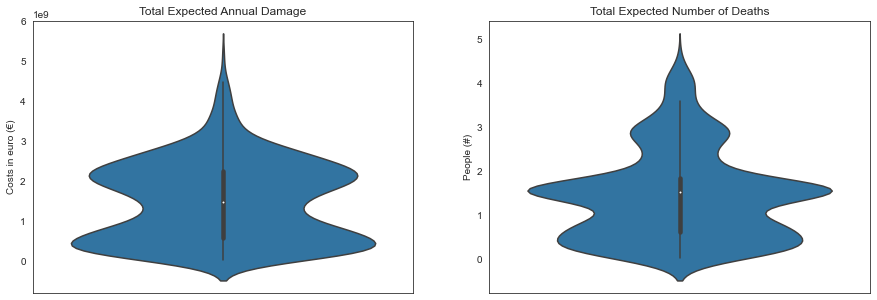

In [70]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.violinplot(data=df_tl["Expected Annual Damage time location aggregate"], ax=axes[0])
sns.violinplot(data=df_tl["Expected Number of Deaths time location aggregate"], ax=axes[1])

axes[0].set_title("Total Expected Annual Damage")
axes[0].set_ylabel('Costs in euro (€)')
axes[0].set(xticklabels = [])
axes[1].set_title("Total Expected Number of Deaths")
axes[1].set_ylabel('People (#)')
axes[1].set(xticklabels = [])

plt.show()

In [78]:
df_t[['A.1_Expected Annual Damage time aggregate',
       'A.2_Expected Annual Damage time aggregate',
       'A.3_Expected Annual Damage time aggregate',
       'A.4_Expected Annual Damage time aggregate',
       'A.5_Expected Annual Damage time aggregate']]

,A.1_Expected Annual Damage time aggregate,A.2_Expected Annual Damage time aggregate,A.3_Expected Annual Damage time aggregate,A.4_Expected Annual Damage time aggregate,A.5_Expected Annual Damage time aggregate
0,0.000000e+00,1.295653e+08,0.000000e+00,0.000000e+00,0.000000e+00
1,2.354776e+09,5.847992e+06,5.543616e+07,0.000000e+00,0.000000e+00
2,2.321737e+09,0.000000e+00,0.000000e+00,0.000000e+00,3.564412e+06
3,1.954980e+09,2.856770e+07,0.000000e+00,0.000000e+00,4.026085e+06
4,0.000000e+00,6.191615e+07,0.000000e+00,5.255887e+05,3.888624e+06
...,...,...,...,...,...
995,2.344847e+09,0.000000e+00,7.226461e+07,1.648794e+07,0.000000e+00
996,1.030584e+09,4.621615e+06,1.633669e+08,1.169571e+08,0.000000e+00
997,2.084937e+09,0.000000e+00,0.000000e+00,3.887181e+06,0.000000e+00
998,5.996125e+08,6.926747e+07,1.919837e+08,0.000000e+00,0.000000e+00


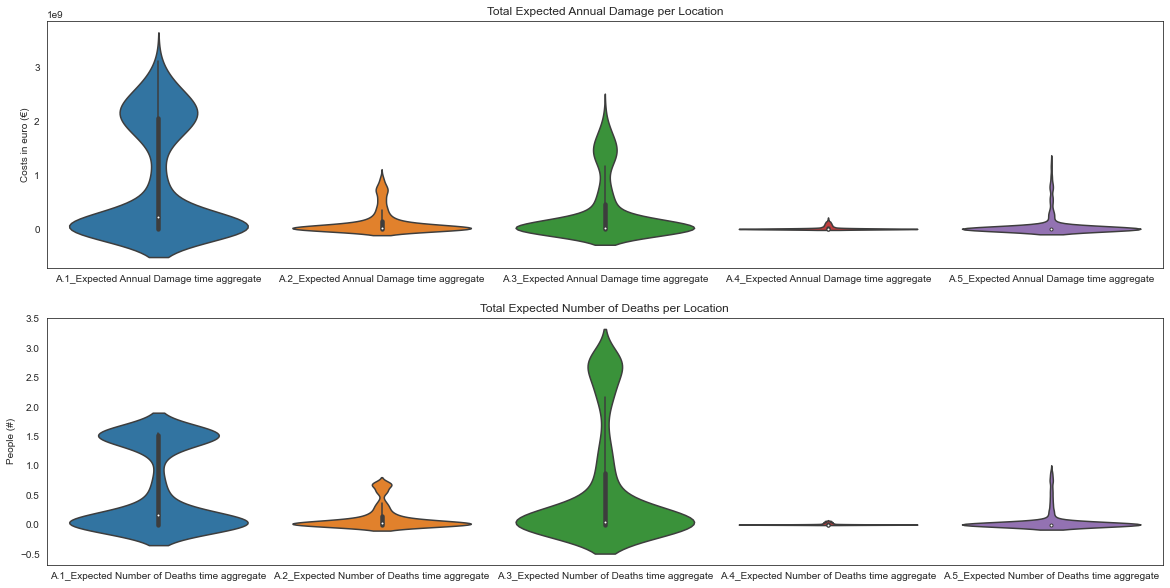

In [84]:
locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
columns_damage = [location + '_' + 'Expected Annual Damage time aggregate'  for location in locations]
columns_deaths = [location + '_' + 'Expected Number of Deaths time aggregate' for location in locations]

f, axes = plt.subplots(2, 1, figsize=(20,10))

sns.violinplot(data=df_t[columns_damage], ax=axes[0], scale='count')
sns.violinplot(data=df_t[columns_deaths], ax=axes[1], scale='count')

axes[0].set_title("Total Expected Annual Damage per Location")
axes[0].set_ylabel('Costs in euro (€)')
axes[1].set_title("Total Expected Number of Deaths per Location")
axes[1].set_ylabel('People (#)')


plt.show()